<a href="https://colab.research.google.com/github/palakga-rg/Topsis-for-Pretained-model-Text-Sentence-Similarity/blob/main/Text_Sentence_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install transformers datasets evaluate accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from scipy.stats import pearsonr

In [3]:
#loading the dataset
from datasets import load_dataset
import pandas as pd

# Load the dataset
dataset = load_dataset("nuvocare/WikiMedical_sentence_similarity", split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/50712 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/21735 [00:00<?, ? examples/s]

In [4]:
df = pd.DataFrame(dataset)


In [5]:
df

,text1,text2,label
0,Econometric studies have shown that this effec...,"""Spinraza access by country"". TreatSMA. 18 Oct...",0
1,"Recurrent silent strokes, with or without clin...","Tagraxofusp, sold under the brand name Elzonri...",0
2,Mutations in the ASS gene reduce the activity ...,Citrullinemia is an autosomal recessive urea c...,1
3,Fungal spores may be viewed directly on hair s...,"The lesions are located on the head, neck, tai...",1
4,The loss of function mutation results in a phe...,Common noninfectious tenosynovitis are: stenos...,0
...,...,...,...
50707,"Intermenstrual bleeding, previously known as m...","Sometimes, breakthrough bleeding is classified...",1
50708,The characteristic feature of arthritis is joi...,Toxic epidermal necrolysis (TEN) is a type of ...,0
50709,Signs and symptoms\nA manic episode is defined...,"In stages II and III mania, however, the patie...",1
50710,"The underdeveloped conjoined twin, Islaam, was...",Labial fusion is a medical condition of the fe...,0


In [6]:
label0 = df[df['label'] == 0].head(1000)
label1 = df[df['label'] == 1].head(1000)

In [7]:
train_dataset = pd.concat([label0, label1])

In [8]:
train_dataset = train_dataset.sample(frac=1).reset_index(drop=True)

In [9]:
train_dataset

,text1,text2,label
0,Some scholars have stated that there is no agr...,Income\nEmployment\nThe United States Departme...,1
1,Hyperventilation is irregular breathing that o...,Cervical lymphadenopathy refers to lymphadenop...,0
2,Laropiprant is a prostaglandin D2 binding drug...,The resulting name niacin was derived from nic...,1
3,Dementia\nSedatives and hypnotics should be av...,Malcolm Lader at the Institute of Psychiatry i...,1
4,Other applications\nJewelry\nBecause of the so...,El Dorado is applied to a legendary story in w...,1
...,...,...,...
1995,Nerve blocks\nNerve blocks that may be used to...,"Unlike other tubulin-targeting drugs, such as ...",0
1996,Attack rates are similar for men and women.The...,"However, it has been shown to have comparable ...",0
1997,Proctitis is an inflammation of the anus and t...,Other treatments may include mesalamine suppos...,1
1998,Anorectal abscess (also known as an anal/recta...,It is unclear whether internal packing of the ...,1


In [10]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [11]:
#Preprocessing the data
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the tokens back into a single string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

In [12]:
train_dataset['text1'] = train_dataset['text1'].apply(preprocess_text)
train_dataset['text2'] = train_dataset['text2'].apply(preprocess_text)

In [13]:
train_dataset

,text1,text2,label
0,scholar stated agreed upon definition homeless...,income employment united state department labo...,1
1,hyperventilation irregular breathing occurs ra...,cervical lymphadenopathy refers lymphadenopath...,0
2,laropiprant prostaglandin d2 binding drug show...,resulting name niacin derived nicotinic acid v...,1
3,dementia sedative hypnotic avoided people deme...,malcolm lader institute psychiatry london esti...,1
4,application jewelry softness pure 24k gold usu...,el dorado applied legendary story precious sto...,1
...,...,...,...
1995,nerve block nerve block may used help pain red...,unlike tubulintargeting drug colchicine inhibi...,0
1996,attack rate similar men womenthe important det...,however shown comparable affinity calcitriol v...,0
1997,proctitis inflammation anus lining rectum affe...,treatment may include mesalamine suppository v...,1
1998,anorectal abscess also known analrectal absces...,unclear whether internal packing perianal absc...,1


In [14]:
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(train_dataset, test_size=0.2, random_state=42)


In [15]:
from tqdm import tqdm

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

def evaluate_model(model, tokenizer, df, batch_size=8):
    num_samples = len(df)
    accuracy_list, precision_list, recall_list, f1_list, roc_list = [], [], [], [], []

    with tqdm(total=num_samples, desc="Evaluating") as pbar:
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)

            inputs = tokenizer(
                df['text1'][start:end].tolist(),
                df['text2'][start:end].tolist(),
                return_tensors='pt',
                padding=True,
                truncation=True
            )
            labels = df['label'][start:end].values

            with torch.no_grad():
                outputs = model(**inputs)

            predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()

            # Update evaluation metrics for each batch
            accuracy = accuracy_score(labels, predictions)
            precision = precision_score(labels, predictions)
            recall = recall_score(labels, predictions)
            f1 = f1_score(labels, predictions)
            roc = roc_auc_score(labels, predictions)

            accuracy_list.append(accuracy)
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
            roc_list.append(roc)

            pbar.update(end - start)

    # Compute average metrics
    accuracy = sum(accuracy_list) / len(accuracy_list)
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1 = sum(f1_list) / len(f1_list)
    mean_roc = sum(roc_list) / len(roc_list)

    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc': mean_roc
    }

    return results

# Define the models
models = {
    'roberta-base': 'roberta-base',
    'bert-base-uncased': 'bert-base-uncased',
    # 'paraphrase-MiniLM-L6-v2':'paraphrase-MiniLM-L6-v2',
    # 'msmarco-distilbert-base-v2': 'msmarco-distilbert-base-v2',
    'albert-base-v2': 'albert-base-v2',
    'distilbert-base-uncased': 'distilbert-base-uncased',
    'xlnet-base-cased': 'xlnet-base-cased',
}

# Store results for each model
results_dict = {}

# Evaluate each model
for model_name, model_key in models.items():
    # Load model and tokenizer
    model = AutoModelForSequenceClassification.from_pretrained(model_key)
    tokenizer = AutoTokenizer.from_pretrained(model_key)

    # Evaluate the model
    results = evaluate_model(model, tokenizer, test_df)

    # Store results in the dictionary
    results_dict[model_name] = results

    # Print evaluation results
    print(f"{model_name}:")
    print(f"Accuracy: {results['accuracy']:.4f}, Precision: {results['precision']:.4f}, Recall: {results['recall']:.4f}, F1 Score: {results['f1']:.4f}")
    print(f"ROC: {results['roc']:.4f}\n")

# Access results_dict to get the evaluation results for each model
print(results_dict)


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Evaluating: 100%|██████████| 400/400 [15:00<00:00,  2.25s/it]


roberta-base:
Accuracy: 0.4700, Precision: 0.4700, Recall: 1.0000, F1 Score: 0.6228
ROC: 0.5000



config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Evaluating: 100%|██████████| 400/400 [12:01<00:00,  1.80s/it]


bert-base-uncased:
Accuracy: 0.5075, Precision: 0.4888, Recall: 1.0000, F1 Score: 0.6397
ROC: 0.5348



config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Evaluating: 100%|██████████| 400/400 [12:42<00:00,  1.91s/it]


albert-base-v2:
Accuracy: 0.4200, Precision: 0.4218, Recall: 0.5913, F1 Score: 0.4669
ROC: 0.4322



config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Evaluating: 100%|██████████| 400/400 [06:30<00:00,  1.03it/s]


distilbert-base-uncased:
Accuracy: 0.4700, Precision: 0.4700, Recall: 1.0000, F1 Score: 0.6228
ROC: 0.5000



config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.weight', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

Evaluating:  16%|█▌        | 64/400 [05:19<27:26,  4.90s/it]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Evaluating:  58%|█████▊    | 232/400 [19:38<14:47,  5.28s/it]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Evaluating: 100%|██████████| 400/400 [33:55<00:00,  5.09s/it]

xlnet-base-cased:
Accuracy: 0.4700, Precision: 0.3907, Recall: 0.3357, F1 Score: 0.3386
ROC: 0.4511

{'roberta-base': {'accuracy': 0.47, 'precision': 0.47, 'recall': 1.0, 'f1': 0.6227834387834391, 'roc': 0.5}, 'bert-base-uncased': {'accuracy': 0.5075, 'precision': 0.4887857142857143, 'recall': 1.0, 'f1': 0.6397276057276059, 'roc': 0.5347619047619048}, 'albert-base-v2': {'accuracy': 0.42, 'precision': 0.4217619047619047, 'recall': 0.5913333333333336, 'f1': 0.4669488289488289, 'roc': 0.43219047619047624}, 'distilbert-base-uncased': {'accuracy': 0.47, 'precision': 0.47, 'recall': 1.0, 'f1': 0.6227834387834391, 'roc': 0.5}, 'xlnet-base-cased': {'accuracy': 0.47, 'precision': 0.3906666666666667, 'recall': 0.3356666666666666, 'f1': 0.3386435786435787, 'roc': 0.4511428571428571}}


In [17]:
# Convert results_dict to a DataFrame
result_df = pd.DataFrame(results_dict).T

# Save DataFrame to a CSV file
result_df.to_csv('result.csv')

# Access results_df to get the evaluation results for each model
print(result_df)

                         accuracy  precision    recall        f1       roc
roberta-base               0.4700   0.470000  1.000000  0.622783  0.500000
bert-base-uncased          0.5075   0.488786  1.000000  0.639728  0.534762
albert-base-v2             0.4200   0.421762  0.591333  0.466949  0.432190
distilbert-base-uncased    0.4700   0.470000  1.000000  0.622783  0.500000
xlnet-base-cased           0.4700   0.390667  0.335667  0.338644  0.451143


In [18]:
!pip install Topsis-Palak-102103608

In [ ]:
!topsis result.csv "1,1,1,1,1" "+,+,+,+,+" final.csv

In [35]:
ans=pd.read_csv('final.csv')

In [36]:
ans

,Unnamed: 0,accuracy,precision,recall,f1,roc,Topsis Score,Rank
0,roberta-base,0.4700,0.470000,1.000000,0.622783,0.500000,0.108295,3.5
1,bert-base-uncased,0.5075,0.488786,1.000000,0.639728,0.534762,0.000000,5.0
2,albert-base-v2,0.4200,0.421762,0.591333,0.466949,0.432190,0.629105,2.0
3,distilbert-base-uncased,0.4700,0.470000,1.000000,0.622783,0.500000,0.108295,3.5
4,xlnet-base-cased,0.4700,0.390667,0.335667,0.338644,0.451143,0.898809,1.0


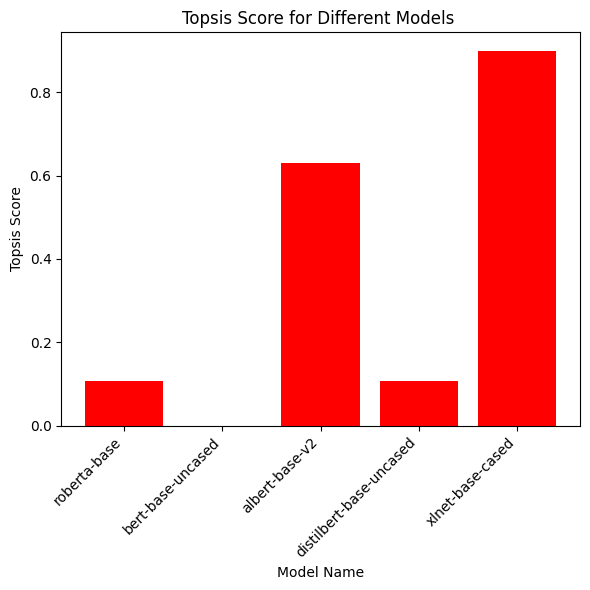

In [37]:
import pandas as pd
import matplotlib.pyplot as plt


model_names = ans['Unnamed: 0']
topsis_scores = ans['Topsis Score']

# Plotting the bar graph
plt.figure(figsize=(6, 6))
plt.bar(model_names, topsis_scores, color='Red')
plt.xlabel('Model Name')
plt.ylabel('Topsis Score')
plt.title('Topsis Score for Different Models ')
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()